<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heart failure data analysis

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not and if there are some driving factors that may lead to heart failure.


##Import useful libraries


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#valutare inserzione seed np.random.seed(123)

##Dataset visualization and data exploration


In the following code snippet a visualization of the data is provided

In [24]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


I check the correlation between attributes in order to try to eliminate one of the two having high correlation between each other

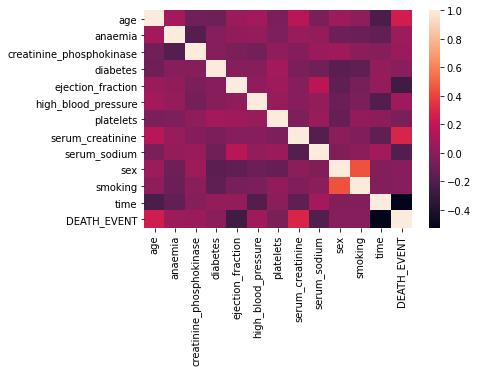

In [25]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
sns.heatmap(corr)
#I notice that that there are no attibutes that are highly correlated one with another so selecting features by imposing a threshold on the correlation seems not to be a good idea
#valuta box plot and the distribution plot for the feature (both before and after the pca)

##Dimesionality Reduction: PCA

Since the dimensionality of the data is quite high and this can decrease the performances in terms of execution time I try to use PCA in order to reduce the number of features.

PCA is affected by scale so features in the data should be standardized in order to assure the best performances.

Standardization means scale the features into unit scale (mean=0, variance=1)


In [26]:
features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']

#Taking the features and placing in an array
x = df.loc[:, features].values


#Separating the target
y = df.loc[:,['DEATH_EVENT']].values#

# Standardizing the features
x = StandardScaler().fit_transform(x)


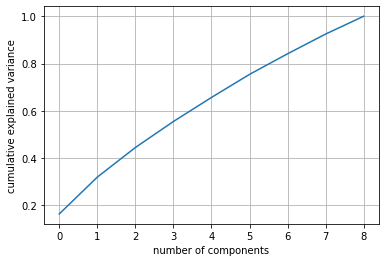

In [35]:
#to choose the correct number of components I plot cumulative explained variance ratio as a function of the number of components.

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#probabilmente sceglierò il 9 perchè copre quasi tutta la  varianza (circa 90%)

pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)#
principalDf = pd.DataFrame(data = principalComponents, columns = ['1', '2','3','4','5','6','7','8','9'])

finalDf = pd.concat([principalDf, df[['DEATH_EVENT']]], axis = 1)

x=principalComponents


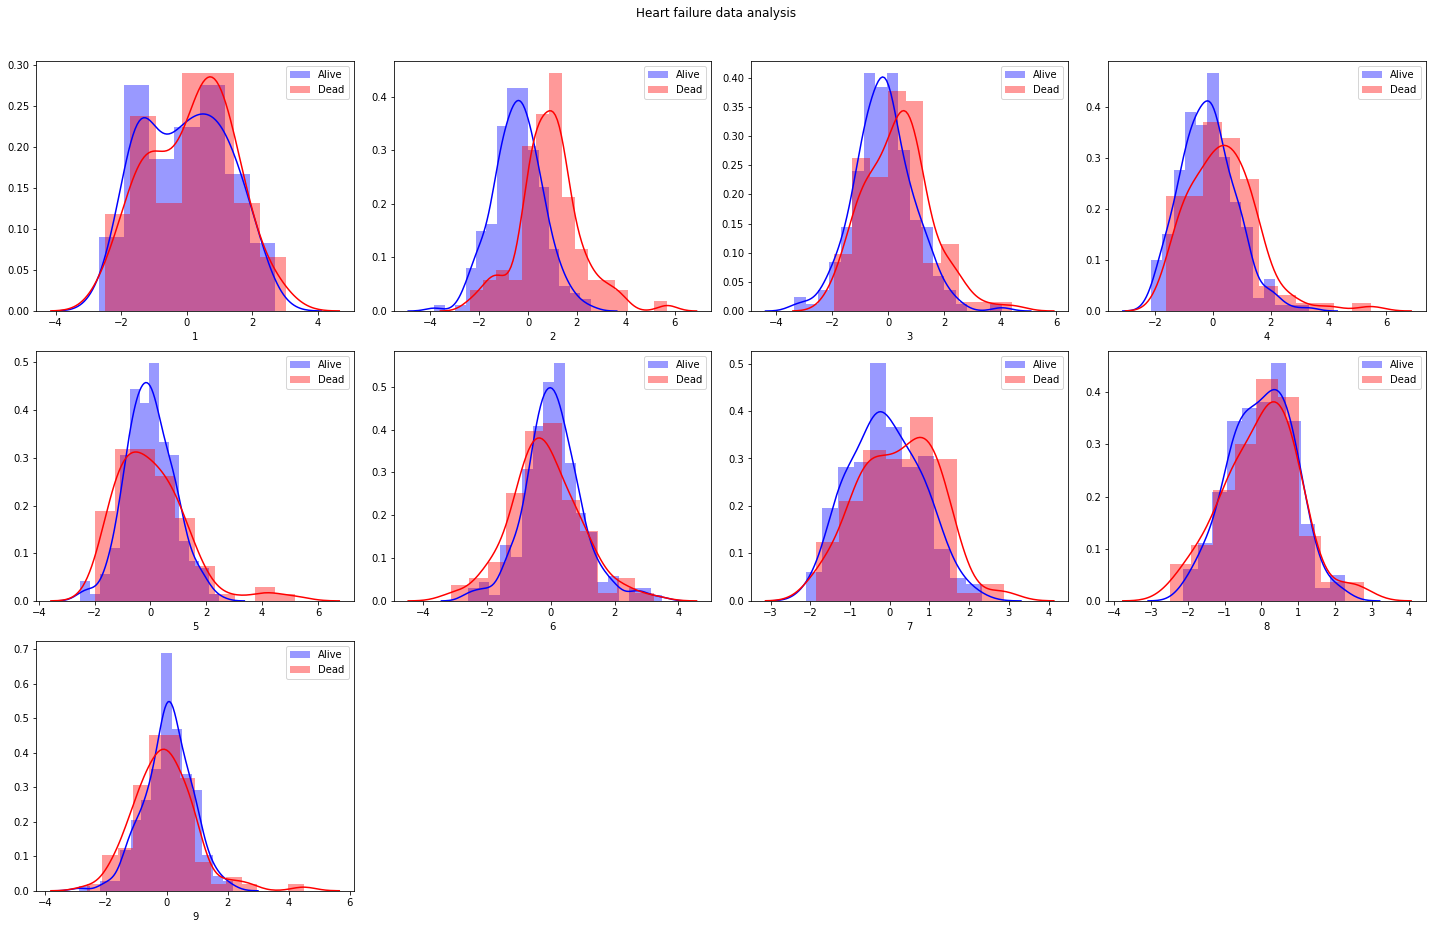

In [28]:
#Visualizing the selected features

fig = plt.figure(figsize = (20, 25))
j = 0
for i in principalDf.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(principalDf[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(principalDf[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#Preparing dataset
I first divide the dataset into training set (50%) and test set(50%)
Then I divide again the test set into validation set(50%) and test set(50%)





In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5)

Since data is a bit unbalanced and in order to reduce overfitting I decided to apply the k-fold cross validation tecnique on 10 folds

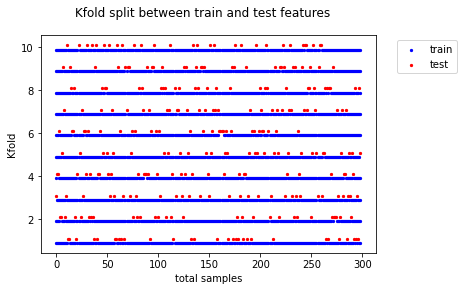

In [55]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="test",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and test features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()